<a href="https://colab.research.google.com/github/aymenchibouti/doctorat/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODEL 2 DATA ORGANIZATION PIPELINE
Loading data files...
Enrollment data loaded: 120542 records
Log data loaded: 8157277 records
Truth data loaded: 120541 records
Data loading completed successfully!
Creating student matrices...
Processing student 1/120542
Processing student 1001/120542
Processing student 2001/120542
Processing student 3001/120542
Processing student 4001/120542
Processing student 5001/120542
Processing student 6001/120542
Processing student 7001/120542
Processing student 8001/120542
Processing student 9001/120542
Processing student 10001/120542
Processing student 11001/120542
Processing student 12001/120542
Processing student 13001/120542
Processing student 14001/120542
Processing student 15001/120542
Processing student 16001/120542
Processing student 17001/120542
Processing student 18001/120542
Processing student 19001/120542
Processing student 20001/120542
Processing student 21001/120542
Processing student 22001/120542
Processing student 23001/120542
Processing stude

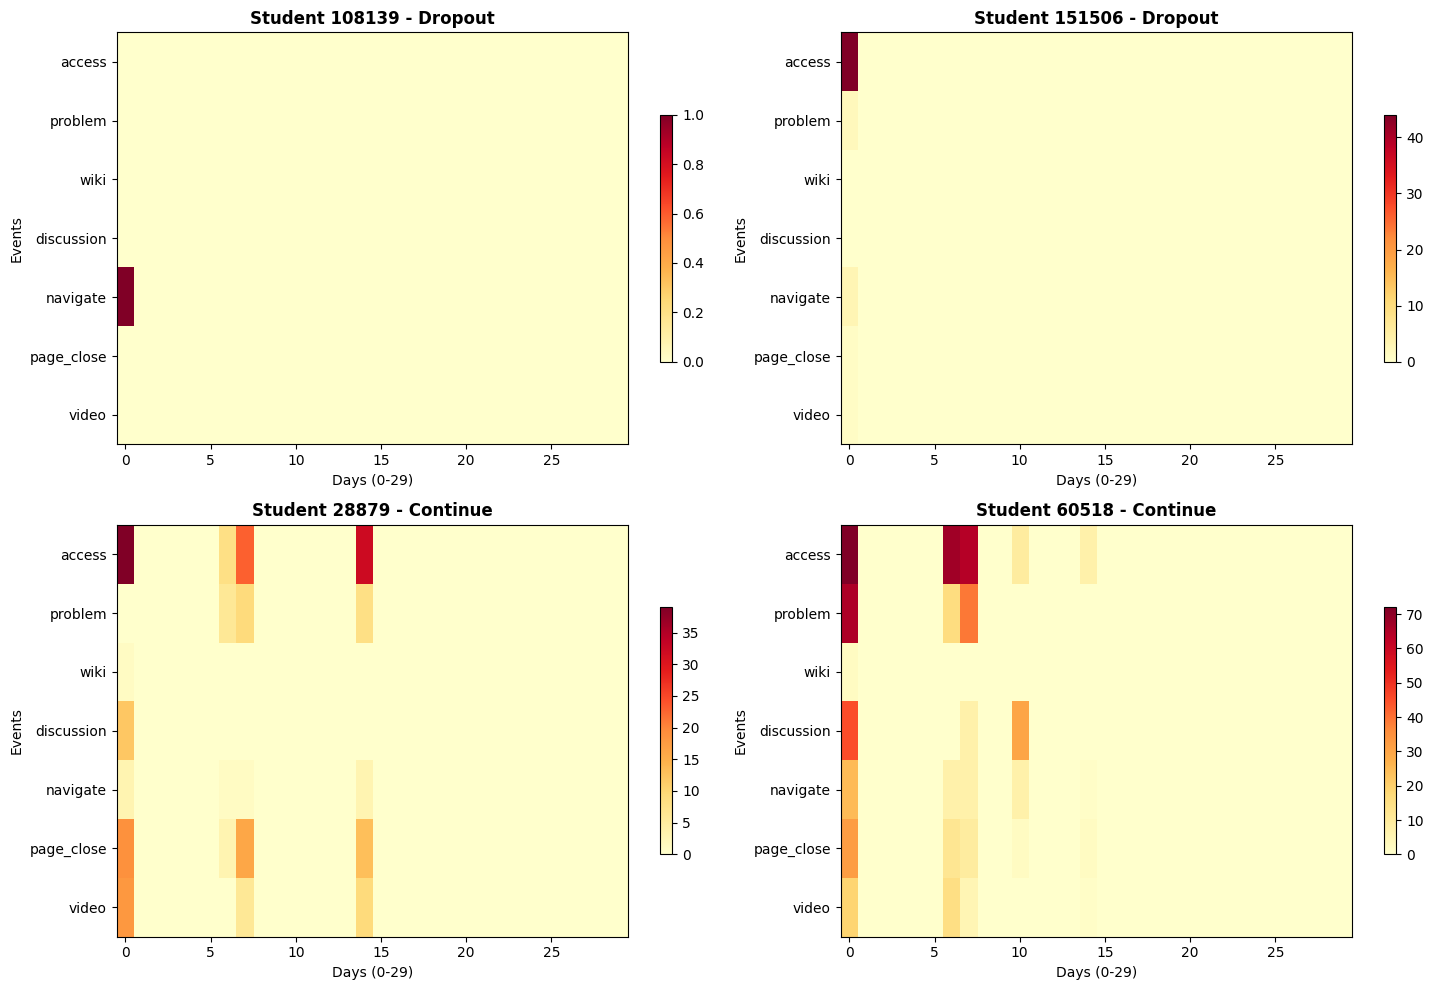

Analyzing data statistics...
Total students: 120541
Total events recorded: 8,156,963
Average events per student: 67.7
Average events per student per day: 2.3

Event type statistics:
  access: 3,112,084 (38.2%)
  problem: 1,261,083 (15.5%)
  wiki: 90,507 (1.1%)
  discussion: 649,259 (8.0%)
  navigate: 1,009,284 (12.4%)
  page_close: 1,237,817 (15.2%)
  video: 796,929 (9.8%)


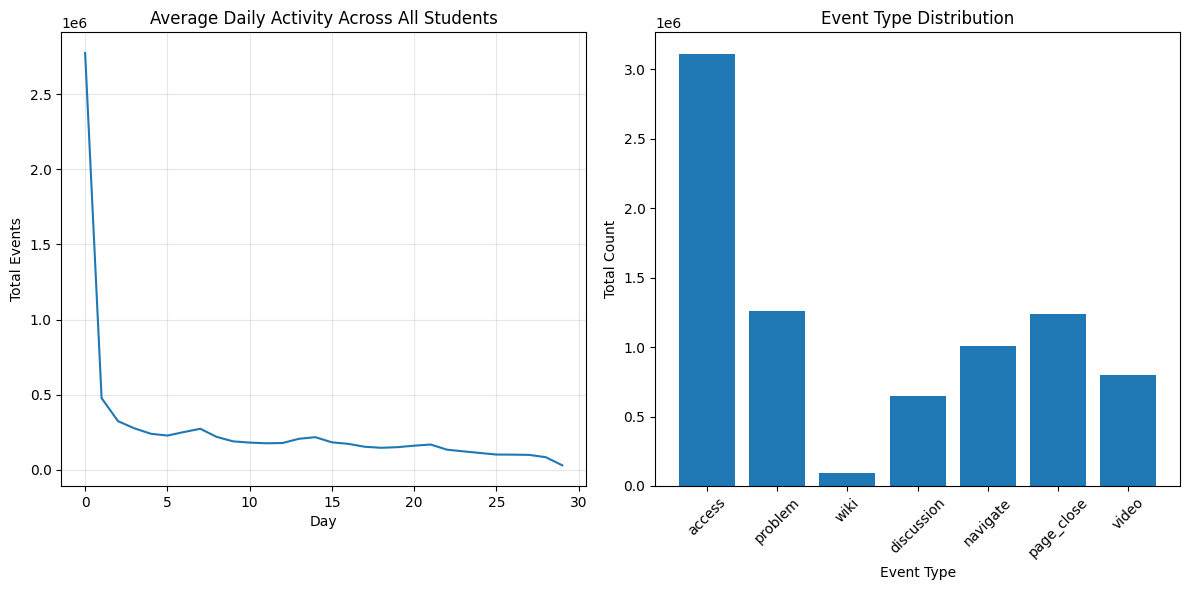

Saving Model 2 data...
Model 2 data saved successfully!
Files created:
- model2_matrices.npy: Student matrices (shape: (120541, 30, 7))
- model2_labels.npy: Dropout labels
- model2_enrollment_ids.npy: Enrollment IDs
- model2_summary.csv: Summary statistics

MODEL 2 ORGANIZATION COMPLETED

Model 2 organization completed successfully!
Created matrices for 120541 students
Matrix shape per student: (30, 7)

Testing data loader...
Loaded Model 2 data:
  Matrices shape: (120541, 30, 7)
  Labels shape: (120541,)
  Dropout rate: 79.3%
Data prepared for CNN: (120541, 30, 7, 1)
Data split completed:
  Training: 72324 samples (79.3% dropout)
  Validation: 24108 samples (79.3% dropout)
  Test: 24109 samples (79.3% dropout)
Data loader test successful!


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

class Model2DataOrganizer:
    """
    Organize data for Model 2: CNN with matrix format (30 days × 7 events)

    Model 2 Structure:
    - Input shape: (30, 7) for each student
    - 30 rows = 30 days
    - 7 columns = 7 events (access, problem, wiki, discussion, navigate, page_close, video)
    - Uses CNN to capture spatial-temporal patterns
    """

    def __init__(self):
        self.enrollment_df = None
        self.log_df = None
        self.truth_df = None
        self.model2_data = None
        self.matrices = None
        self.labels = None
        self.enrollment_ids = None

    def load_data(self):
        """Load all CSV files"""
        print("Loading data files...")

        try:
            # Load enrollment data
            self.enrollment_df = pd.read_csv('enrollment_train.csv')
            print(f"Enrollment data loaded: {len(self.enrollment_df)} records")

            # Load log data
            self.log_df = pd.read_csv('log_train.csv')
            print(f"Log data loaded: {len(self.log_df)} records")

            # Load truth data (handle both possible formats)
            try:
                # Try with headers first
                self.truth_df = pd.read_csv('truth_train.csv')
                if len(self.truth_df.columns) == 2 and self.truth_df.columns[0] == '1':
                    # Rename columns if they are '1' and '0'
                    self.truth_df.columns = ['enrollment_id', 'dropout']
            except:
                # Try without headers
                self.truth_df = pd.read_csv('truth_train.csv', header=None)
                self.truth_df.columns = ['enrollment_id', 'dropout']

            print(f"Truth data loaded: {len(self.truth_df)} records")

            # Convert time to datetime
            self.log_df['time'] = pd.to_datetime(self.log_df['time'])

            print("Data loading completed successfully!")
            return True

        except Exception as e:
            print(f"Error loading data: {e}")
            return False

    def create_student_matrices(self):
        """
        Create 30×7 matrices for each student
        Each matrix represents 30 days × 7 events
        """
        print("Creating student matrices...")

        # Define the 7 main events from the document
        main_events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

        # Get unique enrollment IDs
        enrollment_ids = self.enrollment_df['enrollment_id'].unique()

        matrices = []
        valid_enrollment_ids = []

        for i, enrollment_id in enumerate(enrollment_ids):
            if i % 1000 == 0:
                print(f"Processing student {i+1}/{len(enrollment_ids)}")

            # Get student's logs
            student_logs = self.log_df[self.log_df['enrollment_id'] == enrollment_id].copy()

            if len(student_logs) == 0:
                continue

            # Get course start date for this student
            start_date = student_logs['time'].min()

            # Create 30×7 matrix for this student
            student_matrix = np.zeros((30, 7))

            for day_idx in range(30):  # Days 0 to 29
                day_date = start_date + timedelta(days=day_idx)
                day_end = day_date + timedelta(days=1)

                # Get logs for this specific day
                day_logs = student_logs[
                    (student_logs['time'] >= day_date) &
                    (student_logs['time'] < day_end)
                ]

                # Count events for each of the 7 main events on this day
                for event_idx, event in enumerate(main_events):
                    event_count = len(day_logs[day_logs['event'] == event])
                    student_matrix[day_idx, event_idx] = event_count

            matrices.append(student_matrix)
            valid_enrollment_ids.append(enrollment_id)

        self.matrices = np.array(matrices)
        self.enrollment_ids = np.array(valid_enrollment_ids)

        print(f"Created matrices for {len(matrices)} students")
        print(f"Matrix shape per student: {self.matrices[0].shape}")
        print(f"Total data shape: {self.matrices.shape}")

        return self.matrices

    def merge_with_labels(self):
        """Merge matrices with dropout labels"""
        print("Merging with dropout labels...")

        # Create DataFrame for easier merging
        enrollment_df = pd.DataFrame({'enrollment_id': self.enrollment_ids})

        # Merge with truth data
        merged_df = enrollment_df.merge(self.truth_df, on='enrollment_id', how='left')

        # Get labels in the same order as matrices
        self.labels = merged_df['dropout'].values

        # Remove students without labels
        valid_mask = ~pd.isna(self.labels)
        self.matrices = self.matrices[valid_mask]
        self.enrollment_ids = self.enrollment_ids[valid_mask]
        self.labels = self.labels[valid_mask].astype(int)

        print(f"Final dataset: {len(self.matrices)} students")
        print(f"Dropout rate: {self.labels.mean():.1%}")

        return self.matrices, self.labels

    def visualize_sample_matrices(self, n_samples=4):
        """Visualize sample student matrices"""
        print("Creating sample matrix visualizations...")

        # Select samples: 2 dropout, 2 continue
        dropout_indices = np.where(self.labels == 1)[0]
        continue_indices = np.where(self.labels == 0)[0]

        sample_indices = []
        if len(dropout_indices) >= 2:
            sample_indices.extend(np.random.choice(dropout_indices, 2, replace=False))
        if len(continue_indices) >= 2:
            sample_indices.extend(np.random.choice(continue_indices, 2, replace=False))

        events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()

        for i, idx in enumerate(sample_indices[:4]):
            matrix = self.matrices[idx]
            label = 'Dropout' if self.labels[idx] == 1 else 'Continue'

            im = axes[i].imshow(matrix.T, cmap='YlOrRd', aspect='auto')
            axes[i].set_title(f'Student {self.enrollment_ids[idx]} - {label}', fontweight='bold')
            axes[i].set_xlabel('Days (0-29)')
            axes[i].set_ylabel('Events')
            axes[i].set_yticks(range(7))
            axes[i].set_yticklabels(events)

            # Add colorbar
            plt.colorbar(im, ax=axes[i], shrink=0.6)

        plt.tight_layout()
        plt.savefig('model2_sample_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_data_statistics(self):
        """Analyze data statistics for Model 2"""
        print("Analyzing data statistics...")

        # Overall statistics
        total_students = len(self.matrices)
        total_events = np.sum(self.matrices)
        avg_events_per_student = total_events / total_students
        avg_events_per_day = total_events / (total_students * 30)

        print(f"Total students: {total_students}")
        print(f"Total events recorded: {total_events:,.0f}")
        print(f"Average events per student: {avg_events_per_student:.1f}")
        print(f"Average events per student per day: {avg_events_per_day:.1f}")

        # Event type statistics
        events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']
        event_totals = np.sum(self.matrices, axis=(0, 1))  # Sum across students and days

        print("\nEvent type statistics:")
        for i, event in enumerate(events):
            print(f"  {event}: {event_totals[i]:,.0f} ({event_totals[i]/total_events*100:.1f}%)")

        # Daily activity patterns
        daily_activity = np.sum(self.matrices, axis=(0, 2))  # Sum across students and events

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(range(30), daily_activity)
        plt.title('Average Daily Activity Across All Students')
        plt.xlabel('Day')
        plt.ylabel('Total Events')
        plt.grid(True, alpha=0.3)

        # Event distribution
        plt.subplot(1, 2, 2)
        plt.bar(events, event_totals)
        plt.title('Event Type Distribution')
        plt.xlabel('Event Type')
        plt.ylabel('Total Count')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.savefig('model2_data_statistics.png', dpi=300, bbox_inches='tight')
        plt.show()

        return {
            'total_students': total_students,
            'total_events': total_events,
            'event_totals': dict(zip(events, event_totals)),
            'daily_activity': daily_activity
        }

    def save_model2_data(self):
        """Save organized data for Model 2"""
        print("Saving Model 2 data...")

        # Save matrices as numpy arrays
        np.save('model2_matrices.npy', self.matrices)
        np.save('model2_labels.npy', self.labels)
        np.save('model2_enrollment_ids.npy', self.enrollment_ids)

        # Create summary DataFrame
        summary_df = pd.DataFrame({
            'enrollment_id': self.enrollment_ids,
            'dropout': self.labels,
            'total_events': np.sum(self.matrices, axis=(1, 2)),
            'days_active': np.sum(np.sum(self.matrices, axis=2) > 0, axis=1),
            'avg_daily_events': np.mean(np.sum(self.matrices, axis=2), axis=1)
        })

        # Add individual event totals
        events = ['access', 'problem', 'wiki', 'discussion', 'navigate', 'page_close', 'video']
        for i, event in enumerate(events):
            summary_df[f'total_{event}'] = np.sum(self.matrices[:, :, i], axis=1)

        summary_df.to_csv('model2_summary.csv', index=False)

        print("Model 2 data saved successfully!")
        print("Files created:")
        print("- model2_matrices.npy: Student matrices (shape: {})".format(self.matrices.shape))
        print("- model2_labels.npy: Dropout labels")
        print("- model2_enrollment_ids.npy: Enrollment IDs")
        print("- model2_summary.csv: Summary statistics")

        return summary_df

    def run_model2_organization(self):
        """Run complete Model 2 data organization pipeline"""
        print("=" * 60)
        print("MODEL 2 DATA ORGANIZATION PIPELINE")
        print("=" * 60)

        # Load data
        if not self.load_data():
            return None

        # Create matrices
        self.create_student_matrices()

        # Merge with labels
        self.merge_with_labels()

        # Visualize samples
        self.visualize_sample_matrices()

        # Analyze statistics
        stats = self.analyze_data_statistics()

        # Save data
        summary_df = self.save_model2_data()

        print("\n" + "=" * 60)
        print("MODEL 2 ORGANIZATION COMPLETED")
        print("=" * 60)

        return {
            'matrices': self.matrices,
            'labels': self.labels,
            'enrollment_ids': self.enrollment_ids,
            'summary': summary_df,
            'statistics': stats
        }

class Model2DataLoader:
    """Helper class to load Model 2 data for training"""

    def __init__(self):
        self.X = None
        self.y = None
        self.enrollment_ids = None

    def load_model2_data(self):
        """Load Model 2 data from saved files"""
        try:
            self.X = np.load('model2_matrices.npy')
            self.y = np.load('model2_labels.npy')
            self.enrollment_ids = np.load('model2_enrollment_ids.npy')

            print(f"Loaded Model 2 data:")
            print(f"  Matrices shape: {self.X.shape}")
            print(f"  Labels shape: {self.y.shape}")
            print(f"  Dropout rate: {self.y.mean():.1%}")

            return True
        except FileNotFoundError as e:
            print(f"Model 2 data files not found: {e}")
            print("Please run the organization pipeline first.")
            return False

    def prepare_for_cnn(self, normalize=True):
        """Prepare data for CNN training"""
        if self.X is None:
            if not self.load_model2_data():
                return None, None

        # Add channel dimension for CNN: (samples, height, width, channels)
        X_cnn = self.X.reshape(self.X.shape[0], 30, 7, 1)

        # Normalize if requested
        if normalize:
            # Normalize each matrix individually to preserve relative patterns
            X_cnn_normalized = np.zeros_like(X_cnn)
            for i in range(len(X_cnn)):
                matrix = X_cnn[i, :, :, 0]
                if matrix.max() > 0:  # Avoid division by zero
                    X_cnn_normalized[i, :, :, 0] = matrix / matrix.max()
                else:
                    X_cnn_normalized[i, :, :, 0] = matrix
            X_cnn = X_cnn_normalized

        print(f"Data prepared for CNN: {X_cnn.shape}")

        return X_cnn, self.y

    def split_data(self, test_size=0.2, val_size=0.2, random_state=42):
        """Split data into train/validation/test sets"""
        X_cnn, y = self.prepare_for_cnn()

        if X_cnn is None:
            return None

        # First split: separate test set
        X_temp, X_test, y_temp, y_test = train_test_split(
            X_cnn, y, test_size=test_size, random_state=random_state, stratify=y
        )

        # Second split: separate validation set from remaining data
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted, random_state=random_state, stratify=y_temp
        )

        print(f"Data split completed:")
        print(f"  Training: {X_train.shape[0]} samples ({y_train.mean():.1%} dropout)")
        print(f"  Validation: {X_val.shape[0]} samples ({y_val.mean():.1%} dropout)")
        print(f"  Test: {X_test.shape[0]} samples ({y_test.mean():.1%} dropout)")

        return X_train, X_val, X_test, y_train, y_val, y_test

# Usage example
if __name__ == "__main__":
    # Run Model 2 organization
    organizer = Model2DataOrganizer()
    result = organizer.run_model2_organization()

    if result is not None:
        print("\nModel 2 organization completed successfully!")
        print(f"Created matrices for {len(result['matrices'])} students")
        print(f"Matrix shape per student: {result['matrices'].shape[1:]}")

        # Test data loader
        print("\nTesting data loader...")
        loader = Model2DataLoader()
        data_splits = loader.split_data()

        if data_splits is not None:
            print("Data loader test successful!")
        else:
            print("Data loader test failed!")
    else:
        print("Model 2 organization failed!")

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D,
                                   Dense, Dropout, BatchNormalization, Flatten, Input,
                                   SeparableConv2D, DepthwiseConv2D, Reshape)
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import warnings
warnings.filterwarnings('ignore')

class Model2CNNTrainer:
    """
    CNN trainer for Model 2: 30×7 matrix processing for dropout prediction

    Architecture designs:
    1. Basic CNN: Conv2D layers for spatial pattern recognition
    2. Advanced CNN: Multi-scale feature extraction
    3. Hybrid CNN: Combines spatial and temporal processing
    """

    def __init__(self, data_path=None):
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self.models = {}
        self.histories = {}
        self.predictions = {}
        self.metrics = {}

    def load_data(self):
        """Load and prepare Model 2 data"""
        print("Loading Model 2 data...")

        try:
            from model2_organization import Model2DataLoader

            loader = Model2DataLoader()
            data_splits = loader.split_data(test_size=0.15, val_size=0.15)

            if data_splits is None:
                return False

            self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = data_splits

            print("Data loaded successfully!")
            return True

        except Exception as e:
            print(f"Error loading data: {e}")
            return False

    def build_basic_cnn(self, input_shape=(30, 7, 1)):
        """
        Build basic CNN for 30×7 matrix processing

        Architecture:
        - Conv2D layers to detect local patterns
        - MaxPooling for dimensionality reduction
        - Dense layers for classification
        """
        model = Sequential([
            Input(shape=input_shape, name='input'),

            # First convolutional block
            Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1'),
            BatchNormalization(name='bn1'),
            MaxPooling2D((2, 2), name='pool1'),
            Dropout(0.25, name='dropout1'),

            # Second convolutional block
            Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2'),
            BatchNormalization(name='bn2'),
            MaxPooling2D((2, 2), name='pool2'),
            Dropout(0.25, name='dropout2'),

            # Third convolutional block
            Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3'),
            BatchNormalization(name='bn3'),
            Dropout(0.25, name='dropout3'),

            # Global pooling and dense layers
            GlobalAveragePooling2D(name='global_pool'),
            Dense(128, activation='relu', name='dense1'),
            Dropout(0.5, name='dropout4'),
            Dense(64, activation='relu', name='dense2'),
            Dropout(0.3, name='dropout5'),
            Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    def build_advanced_cnn(self, input_shape=(30, 7, 1)):
        """
        Build advanced CNN with multi-scale feature extraction

        Architecture:
        - Multiple parallel convolutional paths
        - Different kernel sizes for multi-scale features
        - Residual connections
        """
        inputs = Input(shape=input_shape, name='input')

        # Path 1: Small kernels for fine details
        path1 = Conv2D(32, (1, 1), activation='relu', padding='same')(inputs)
        path1 = Conv2D(32, (3, 3), activation='relu', padding='same')(path1)

        # Path 2: Medium kernels for medium patterns
        path2 = Conv2D(32, (1, 1), activation='relu', padding='same')(inputs)
        path2 = Conv2D(32, (5, 3), activation='relu', padding='same')(path2)

        # Path 3: Large kernels for broad patterns
        path3 = Conv2D(32, (1, 1), activation='relu', padding='same')(inputs)
        path3 = Conv2D(32, (7, 3), activation='relu', padding='same')(path3)

        # Path 4: Pooling path
        path4 = MaxPooling2D((3, 3), strides=1, padding='same')(inputs)
        path4 = Conv2D(32, (1, 1), activation='relu', padding='same')(path4)

        # Concatenate all paths
        merged = tf.keras.layers.Concatenate(axis=-1)([path1, path2, path3, path4])

        # Additional processing
        x = BatchNormalization()(merged)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Second multi-scale block
        path1_2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        path2_2 = Conv2D(64, (5, 3), activation='relu', padding='same')(x)

        merged_2 = tf.keras.layers.Concatenate(axis=-1)([path1_2, path2_2])
        x = BatchNormalization()(merged_2)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Final layers
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs, name='advanced_cnn')

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    def build_temporal_aware_cnn(self, input_shape=(30, 7, 1)):
        """
        Build CNN that's aware of temporal structure

        Architecture:
        - Separate processing for temporal (days) and feature (events) dimensions
        - 1D convolutions along temporal dimension
        - 2D convolutions for spatial patterns
        """
        inputs = Input(shape=input_shape, name='input')

        # Temporal processing (along days dimension)
        # Reshape to treat as 1D temporal sequence
        temporal_input = Reshape((30, 7))(inputs)  # Remove channel dimension temporarily

        # Process temporally with different window sizes
        temp_conv1 = tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same')(temporal_input)
        temp_conv2 = tf.keras.layers.Conv1D(32, 5, activation='relu', padding='same')(temporal_input)
        temp_conv3 = tf.keras.layers.Conv1D(32, 7, activation='relu', padding='same')(temporal_input)

        # Combine temporal features
        temporal_features = tf.keras.layers.Concatenate(axis=-1)([temp_conv1, temp_conv2, temp_conv3])
        temporal_features = Reshape((30, 7, -1))(temporal_features)  # Reshape back for 2D conv

        # Spatial processing (2D patterns)
        spatial_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
        spatial_conv2 = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)

        # Combine spatial features
        spatial_features = tf.keras.layers.Concatenate(axis=-1)([spatial_conv1, spatial_conv2])

        # Merge temporal and spatial features
        merged = tf.keras.layers.Concatenate(axis=-1)([temporal_features, spatial_features])

        # Additional processing
        x = BatchNormalization()(merged)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D((2, 2))(x)
        x = Dropout(0.25)(x)

        # Final layers
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.3)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs, name='temporal_aware_cnn')

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    def build_separable_cnn(self, input_shape=(30, 7, 1)):
        """
        Build lightweight CNN using separable convolutions

        Architecture:
        - SeparableConv2D for efficient processing
        - Fewer parameters while maintaining performance
        """
        model = Sequential([
            Input(shape=input_shape, name='input'),

            # First separable block
            SeparableConv2D(32, (3, 3), activation='relu', padding='same', name='sep_conv1'),
            BatchNormalization(name='bn1'),
            MaxPooling2D((2, 2), name='pool1'),
            Dropout(0.25, name='dropout1'),

            # Second separable block
            SeparableConv2D(64, (3, 3), activation='relu', padding='same', name='sep_conv2'),
            BatchNormalization(name='bn2'),
            MaxPooling2D((2, 2), name='pool2'),
            Dropout(0.25, name='dropout2'),

            # Third separable block
            SeparableConv2D(128, (3, 3), activation='relu', padding='same', name='sep_conv3'),
            BatchNormalization(name='bn3'),
            Dropout(0.25, name='dropout3'),

            # Global pooling and dense layers
            GlobalAveragePooling2D(name='global_pool'),
            Dense(128, activation='relu', name='dense1'),
            Dropout(0.5, name='dropout4'),
            Dense(64, activation='relu', name='dense2'),
            Dropout(0.3, name='dropout5'),
            Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall']
        )

        return model

    def train_model(self, model, model_name, epochs=100, batch_size=32):
        """Train a single model"""
        print(f"\nTraining {model_name}...")
        print(f"Model parameters: {model.count_params():,}")

        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=8,
                min_lr=1e-7,
                verbose=1
            ),
            ModelCheckpoint(
                f'{model_name.lower().replace(" ", "_")}_model.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        # Train model
        history = model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        self.models[model_name] = model
        self.histories[model_name] = history

        return history

    def train_all_models(self, epochs=100, batch_size=32):
        """Train all CNN models"""
        print("=" * 60)
        print("TRAINING ALL MODEL 2 CNN ARCHITECTURES")
        print("=" * 60)

        # Build and train models
        models_to_train = [
            ('Basic CNN', self.build_basic_cnn),
            ('Advanced CNN', self.build_advanced_cnn),
            ('Temporal-Aware CNN', self.build_temporal_aware_cnn),
            ('Separable CNN', self.build_separable_cnn)
        ]

        for model_name, model_builder in models_to_train:
            model = model_builder()
            print(f"\n{model_name} Architecture:")
            model.summary()

            self.train_model(model, model_name, epochs, batch_size)

    def evaluate_models(self):
        """Evaluate all trained models"""
        print("\n" + "=" * 60)
        print("EVALUATING ALL MODELS")
        print("=" * 60)

        for model_name, model in self.models.items():
            print(f"\nEvaluating {model_name}...")

            # Predictions
            pred_proba = model.predict(self.X_test, verbose=0)
            pred_binary = (pred_proba > 0.5).astype(int).flatten()

            # Calculate metrics
            metrics = {
                'accuracy': accuracy_score(self.y_test, pred_binary),
                'precision': precision_score(self.y_test, pred_binary),
                'recall': recall_score(self.y_test, pred_binary),
                'f1_score': f1_score(self.y_test, pred_binary),
                'roc_auc': roc_auc_score(self.y_test, pred_proba)
            }

            self.predictions[model_name] = {
                'probabilities': pred_proba.flatten(),
                'binary': pred_binary
            }
            self.metrics[model_name] = metrics

            print(f"Results for {model_name}:")
            for metric, value in metrics.items():
                print(f"  {metric.upper()}: {value:.4f}")

        # Create comparison DataFrame
        comparison_df = pd.DataFrame(self.metrics).T
        print(f"\n{comparison_df.round(4)}")

        return comparison_df

    def plot_training_histories(self):
        """Plot training histories for all models"""
        n_models = len(self.histories)
        fig, axes = plt.subplots(n_models, 4, figsize=(20, 5*n_models))

        if n_models == 1:
            axes = axes.reshape(1, -1)

        metrics = ['loss', 'accuracy', 'precision', 'recall']

        for i, (model_name, history) in enumerate(self.histories.items()):
            for j, metric in enumerate(metrics):
                axes[i, j].plot(history.history[metric], label=f'Train {metric}')
                axes[i, j].plot(history.history[f'val_{metric}'], label=f'Val {metric}')
                axes[i, j].set_title(f'{model_name} - {metric.title()}')
                axes[i, j].set_xlabel('Epoch')
                axes[i, j].set_ylabel(metric.title())
                axes[i, j].legend()
                axes[i, j].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('model2_training_histories.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrices(self):
        """Plot confusion matrices for all models"""
        n_models = len(self.models)
        cols = min(2, n_models)
        rows = (n_models + cols - 1) // cols

        fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))

        if n_models == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if cols == 1 else axes
        else:
            axes = axes.flatten()

        for i, (model_name, _) in enumerate(self.models.items()):
            if i >= len(axes):
                break

            pred_binary = self.predictions[model_name]['binary']
            cm = confusion_matrix(self.y_test, pred_binary)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
            axes[i].set_title(f'{model_name}', fontweight='bold')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

        # Hide unused subplots
        for i in range(len(self.models), len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()
        plt.savefig('model2_confusion_matrices.png', dpi=300, bbox_inches='tight')
        plt.show()

    def analyze_feature_maps(self, model_name='Basic CNN', sample_idx=0):
        """Analyze feature maps from convolutional layers"""
        if model_name not in self.models:
            print(f"Model {model_name} not found!")
            return

        model = self.models[model_name]
        sample_input = self.X_test[sample_idx:sample_idx+1]

        # Get outputs from convolutional layers
        conv_layers = [layer for layer in model.layers if 'conv' in layer.name.lower()]

        if not conv_layers:
            print("No convolutional layers found!")
            return

        # Create model to extract feature maps
        feature_extractor = Model(inputs=model.input,
                                outputs=[layer.output for layer in conv_layers[:3]])  # First 3 conv layers

        feature_maps = feature_extractor.predict(sample_input, verbose=0)

        # Plot feature maps
        fig, axes = plt.subplots(1, len(feature_maps), figsize=(15, 5))

        if len(feature_maps) == 1:
            axes = [axes]

        for i, fmap in enumerate(feature_maps):
            # Take the first channel of the first sample
            map_to_plot = fmap[0, :, :, 0]

            im = axes[i].imshow(map_to_plot, cmap='viridis')
            axes[i].set_title(f'Layer {i+1}: {conv_layers[i].name}')
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], shrink=0.6)

        actual_label = 'Dropout' if self.y_test[sample_idx] == 1 else 'Continue'
        pred_proba = self.predictions[model_name]['probabilities'][sample_idx]
        pred_label = 'Dropout' if pred_proba > 0.5 else 'Continue'

        plt.suptitle(f'Feature Maps - Actual: {actual_label}, Predicted: {pred_label} (prob: {pred_proba:.3f})',
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('model2_feature_maps.png', dpi=300, bbox_inches='tight')
        plt.show()

    def run_complete_pipeline(self, epochs=100, batch_size=32):
        """Run complete Model 2 CNN training pipeline"""
        print("=" * 80)
        print("MODEL 2 CNN TRAINING PIPELINE")
        print("=" * 80)

        # Load data
        if not self.load_data():
            print("Failed to load data!")
            return None

        # Train all models
        self.train_all_models(epochs, batch_size)

        # Evaluate models
        results = self.evaluate_models()

        # Create visualizations
        self.plot_training_histories()
        self.plot_confusion_matrices()
        self.analyze_feature_maps()

        # Save results
        results.to_csv('model2_cnn_results.csv')

        print("\n" + "=" * 80)
        print("MODEL 2 CNN TRAINING COMPLETED")
        print("=" * 80)
        print("Generated files:")
        print("- basic_cnn_model.h5")
        print("- advanced_cnn_model.h5")
        print("- temporal_aware_cnn_model.h5")
        print("- separable_cnn_model.h5")
        print("- model2_training_histories.png")
        print("- model2_confusion_matrices.png")
        print("- model2_feature_maps.png")
        print("- model2_cnn_results.csv")

        return results

# Cross-validation for CNN models
class Model2CrossValidator:
    """Cross-validation for Model 2 CNN models"""

    def __init__(self):
        self.X = None
        self.y = None

    def load_data(self):
        """Load full dataset for cross-validation"""
        from model2_organization import Model2DataLoader

        loader = Model2DataLoader()
        self.X, self.y = loader.prepare_for_cnn()

        return self.X is not None

    def cross_validate_model(self, model_builder, n_folds=5, epochs=50):
        """Perform cross-validation for a model"""
        if not self.load_data():
            return None

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(self.X, self.y)):
            print(f"\nFold {fold + 1}/{n_folds}")

            X_train_fold, X_val_fold = self.X[train_idx], self.X[val_idx]
            y_train_fold, y_val_fold = self.y[train_idx], self.y[val_idx]

            # Build and train model
            model = model_builder()

            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            model.fit(X_train_fold, y_train_fold,
                     validation_data=(X_val_fold, y_val_fold),
                     epochs=epochs, batch_size=32, verbose=0,
                     callbacks=[early_stopping])

            # Evaluate
            pred_proba = model.predict(X_val_fold, verbose=0)
            pred_binary = (pred_proba > 0.5).astype(int).flatten()
            f1 = f1_score(y_val_fold, pred_binary)
            cv_scores.append(f1)

            print(f"Fold {fold + 1} F1-Score: {f1:.4f}")

        mean_score = np.mean(cv_scores)
        std_score = np.std(cv_scores)

        print(f"\nCross-validation results:")
        print(f"Mean F1-Score: {mean_score:.4f} ± {std_score:.4f}")

        return cv_scores

# Usage example
if __name__ == "__main__":
    # Train Model 2 CNNs
    trainer = Model2CNNTrainer()
    results = trainer.run_complete_pipeline(epochs=50, batch_size=32)

    if results is not None:
        print("\nBest model by F1-Score:")
        best_model = results['f1_score'].idxmax()
        best_f1 = results.loc[best_model, 'f1_score']
        print(f"{best_model}: {best_f1:.4f}")

MODEL 2 CNN TRAINING PIPELINE
Loading Model 2 data...
Error loading data: No module named 'model2_organization'
Failed to load data!


In [ ]:
#!/usr/bin/env python3
"""
Complete Model 2 Pipeline: CNN 30×7 Matrix Processing for Dropout Prediction

This script provides a comprehensive pipeline for:
1. Data organization into 30×7 matrices
2. CNN model training with multiple architectures
3. Evaluation and comparison with Model 1
4. Visualization and analysis

Usage:
    python model2_complete_pipeline.py [--mode MODE] [--epochs EPOCHS]

Modes:
    - organize: Data organization only
    - train: CNN training only (requires organized data)
    - full: Complete pipeline (organize + train)
    - evaluate: Evaluation and comparison
"""

import argparse
import sys
import os
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

def check_data_files():
    """Check if the required data files exist"""
    required_files = [
        'enrollment_train.csv',
        'log_train spliting.csv',
        'truth_train.csv'
    ]

    missing_files = []
    for file in required_files:
        if not os.path.exists(file):
            missing_files.append(file)

    if missing_files:
        print("Error: Missing required data files:")
        for file in missing_files:
            print(f"  - {file}")
        return False

    return True

def run_data_organization():
    """Run Model 2 data organization"""
    print("=" * 60)
    print("MODEL 2 DATA ORGANIZATION")
    print("=" * 60)

    try:
        from model2_organization import Model2DataOrganizer

        organizer = Model2DataOrganizer()
        result = organizer.run_model2_organization()

        if result is not None:
            print("\nData organization completed successfully!")
            print(f"Created matrices for {len(result['matrices'])} students")
            print(f"Matrix shape per student: {result['matrices'].shape[1:]}")
            return True
        else:
            print("Data organization failed!")
            return False

    except Exception as e:
        print(f"Error during data organization: {e}")
        return False

def run_cnn_training(epochs=100, batch_size=32):
    """Run CNN model training"""
    print("=" * 60)
    print("MODEL 2 CNN TRAINING")
    print("=" * 60)

    try:
        from model2_cnn_training import Model2CNNTrainer

        trainer = Model2CNNTrainer()
        results = trainer.run_complete_pipeline(epochs=epochs, batch_size=batch_size)

        if results is not None:
            print("\nCNN training completed successfully!")
            return results
        else:
            print("CNN training failed!")
            return None

    except Exception as e:
        print(f"Error during CNN training: {e}")
        return None

def run_model_comparison():
    """Compare Model 2 with Model 1 if available"""
    print("=" * 60)
    print("MODEL COMPARISON")
    print("=" * 60)

    try:
        # Load Model 2 results
        model2_results = None
        if os.path.exists('model2_cnn_results.csv'):
            model2_results = pd.read_csv('model2_cnn_results.csv', index_col=0)
            print("Model 2 Results:")
            print(model2_results.round(4))

        # Load Model 1 results if available
        model1_results = None
        if os.path.exists('model_comparison_results.csv'):
            model1_results = pd.read_csv('model_comparison_results.csv', index_col=0)
            print("\nModel 1 Results (for comparison):")
            print(model1_results.round(4))

        # Combined comparison
        if model2_results is not None and model1_results is not None:
            print("\n" + "=" * 80)
            print("COMPREHENSIVE MODEL COMPARISON")
            print("=" * 80)

            # Find best models from each approach
            best_model1 = model1_results['f1_score'].idxmax()
            best_model1_f1 = model1_results.loc[best_model1, 'f1_score']

            best_model2 = model2_results['f1_score'].idxmax()
            best_model2_f1 = model2_results.loc[best_model2, 'f1_score']

            print(f"Best Model 1: {best_model1} (F1: {best_model1_f1:.4f})")
            print(f"Best Model 2: {best_model2} (F1: {best_model2_f1:.4f})")

            if best_model2_f1 > best_model1_f1:
                improvement = ((best_model2_f1 - best_model1_f1) / best_model1_f1) * 100
                print(f"\nModel 2 shows {improvement:.1f}% improvement over Model 1! 🎉")
            else:
                difference = ((best_model1_f1 - best_model2_f1) / best_model1_f1) * 100
                print(f"\nModel 1 still performs {difference:.1f}% better than Model 2")

            # Create combined results
            combined_results = pd.concat([
                model1_results,
                model2_results
            ])
            combined_results.to_csv('model1_vs_model2_comparison.csv')
            print("\nSaved combined comparison to: model1_vs_model2_comparison.csv")

            return combined_results

        return model2_results

    except Exception as e:
        print(f"Error during model comparison: {e}")
        return None

def create_model2_summary_report(organization_success=False, training_results=None, comparison_results=None):
    """Create comprehensive summary report for Model 2"""
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    report = []
    report.append("=" * 80)
    report.append("MODEL 2 PIPELINE SUMMARY REPORT")
    report.append("=" * 80)
    report.append(f"Generated on: {timestamp}")
    report.append("")

    # Data Organization Summary
    report.append("DATA ORGANIZATION")
    report.append("-" * 40)
    if organization_success:
        report.append("✓ Data organization completed successfully")
        if os.path.exists('model2_matrices.npy'):
            matrices = np.load('model2_matrices.npy')
            report.append(f"  - Created matrices for {len(matrices)} students")
            report.append(f"  - Matrix shape per student: {matrices.shape[1:]} (30 days × 7 events)")

            labels = np.load('model2_labels.npy')
            dropout_rate = labels.mean()
            report.append(f"  - Dropout rate: {dropout_rate:.1%}")
    else:
        report.append("✗ Data organization failed or not completed")

    # CNN Training Summary
    report.append("\nCNN MODEL TRAINING")
    report.append("-" * 40)
    if training_results is not None:
        report.append("✓ CNN training completed successfully")

        best_model = training_results['f1_score'].idxmax()
        best_f1 = training_results.loc[best_model, 'f1_score']
        best_accuracy = training_results.loc[best_model, 'accuracy']
        best_precision = training_results.loc[best_model, 'precision']
        best_recall = training_results.loc[best_model, 'recall']

        report.append(f"  - Best Model: {best_model}")
        report.append(f"  - F1-Score: {best_f1:.4f}")
        report.append(f"  - Accuracy: {best_accuracy:.4f}")
        report.append(f"  - Precision: {best_precision:.4f}")
        report.append(f"  - Recall: {best_recall:.4f}")

        # Performance assessment
        if best_f1 > 0.8:
            report.append("  - Performance Level: Excellent ✓")
        elif best_f1 > 0.7:
            report.append("  - Performance Level: Good ✓")
        elif best_f1 > 0.6:
            report.append("  - Performance Level: Acceptable ⚠")
        else:
            report.append("  - Performance Level: Needs Improvement ✗")

        # Model comparison
        report.append("\n  Model Performance Summary:")
        for model_name in training_results.index:
            f1 = training_results.loc[model_name, 'f1_score']
            acc = training_results.loc[model_name, 'accuracy']
            report.append(f"    {model_name}: F1={f1:.4f}, Acc={acc:.4f}")
    else:
        report.append("✗ CNN training failed or not completed")

    # Model Comparison
    if comparison_results is not None:
        report.append("\nMODEL 1 vs MODEL 2 COMPARISON")
        report.append("-" * 40)

        # Find Model 1 and Model 2 best performers
        model1_models = [idx for idx in comparison_results.index if 'LSTM' in idx or 'ANN' in idx]
        model2_models = [idx for idx in comparison_results.index if 'CNN' in idx]

        if model1_models and model2_models:
            model1_best_f1 = comparison_results.loc[model1_models, 'f1_score'].max()
            model2_best_f1 = comparison_results.loc[model2_models, 'f1_score'].max()

            report.append(f"Best Model 1 F1-Score: {model1_best_f1:.4f}")
            report.append(f"Best Model 2 F1-Score: {model2_best_f1:.4f}")

            if model2_best_f1 > model1_best_f1:
                improvement = ((model2_best_f1 - model1_best_f1) / model1_best_f1) * 100
                report.append(f"Model 2 improvement: +{improvement:.1f}% ✓")
            else:
                difference = ((model1_best_f1 - model2_best_f1) / model1_best_f1) * 100
                report.append(f"Model 1 still better by: {difference:.1f}%")

    # Technical Insights
    report.append("\nTECHNICAL INSIGHTS")
    report.append("-" * 40)
    report.append("Model 2 Advantages:")
    report.append("  • Preserves spatial-temporal structure in student behavior")
    report.append("  • CNNs detect local patterns in day-event combinations")
    report.append("  • Translation invariance helps with timing variations")
    report.append("  • Hierarchical feature learning from low-level to high-level patterns")
    report.append("  • Parameter sharing reduces overfitting risk")

    # Generated Files
    report.append("\nGENERATED FILES")
    report.append("-" * 40)

    expected_files = [
        "model2_matrices.npy",
        "model2_labels.npy",
        "model2_summary.csv",
        "model2_sample_matrices.png",
        "model2_data_statistics.png",
        "basic_cnn_model.h5",
        "advanced_cnn_model.h5",
        "temporal_aware_cnn_model.h5",
        "separable_cnn_model.h5",
        "model2_training_histories.png",
        "model2_confusion_matrices.png",
        "model2_feature_maps.png",
        "model2_cnn_results.csv"
    ]

    for file in expected_files:
        if os.path.exists(file):
            report.append(f"✓ {file}")
        else:
            report.append(f"✗ {file}")

    # Recommendations
    report.append("\nRECOMMENDATIONS")
    report.append("-" * 40)
    if training_results is not None and training_results['f1_score'].max() > 0.75:
        report.append("✓ Model 2 shows promising results for dropout prediction")
        report.append("✓ Consider deploying the best CNN model for production use")
        report.append("✓ Monitor model performance on new data")
    else:
        report.append("⚠ Consider additional feature engineering or data augmentation")
        report.append("⚠ Try ensemble methods combining Model 1 and Model 2")
        report.append("⚠ Collect more data if possible")

    # Save report
    with open('model2_summary_report.txt', 'w') as f:
        f.write('\n'.join(report))

    print('\n'.join(report))
    return report

def main():
    """Main execution function"""
    parser = argparse.ArgumentParser(
        description='Complete Model 2 Pipeline: CNN 30×7 Matrix Processing',
        formatter_class=argparse.RawDescriptionHelpFormatter,
        epilog="""
Examples:
    python model2_complete_pipeline.py --mode organize
    python model2_complete_pipeline.py --mode train --epochs 50
    python model2_complete_pipeline.py --mode full --epochs 100
    python model2_complete_pipeline.py --mode evaluate
        """
    )

    parser.add_argument('--mode',
                       choices=['organize', 'train', 'full', 'evaluate'],
                       default='full',
                       help='Pipeline mode (default: full)')

    parser.add_argument('--epochs',
                       type=int,
                       default=100,
                       help='Number of training epochs (default: 100)')

    parser.add_argument('--batch_size',
                       type=int,
                       default=32,
                       help='Batch size for training (default: 32)')

    args = parser.parse_args()

    # Print header
    print("=" * 80)
    print("MODEL 2 COMPLETE PIPELINE: CNN 30×7 MATRIX PROCESSING")
    print("=" * 80)
    print(f"Mode: {args.mode}")
    print(f"Epochs: {args.epochs}")
    print(f"Batch Size: {args.batch_size}")
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 80)

    # Check data files for organize and full modes
    if args.mode in ['organize', 'full']:
        if not check_data_files():
            sys.exit(1)

    # Initialize results
    organization_success = False
    training_results = None
    comparison_results = None

    try:
        # Execute based on mode
        if args.mode in ['organize', 'full']:
            organization_success = run_data_organization()
            if not organization_success and args.mode == 'full':
                print("Data organization failed, stopping pipeline.")
                sys.exit(1)

        if args.mode in ['train', 'full']:
            # Check if organized data exists
            if not os.path.exists('model2_matrices.npy'):
                print("Error: Model 2 data not found! Please run organization first.")
                sys.exit(1)

            training_results = run_cnn_training(args.epochs, args.batch_size)

        if args.mode == 'evaluate' or (args.mode == 'full' and training_results is not None):
            comparison_results = run_model_comparison()

        # Create summary report
        create_model2_summary_report(organization_success, training_results, comparison_results)

        print("\n" + "=" * 80)
        print("MODEL 2 PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print("Key files generated:")
        print("- model2_summary_report.txt: Complete pipeline summary")
        print("- model2_matrices.npy: Student behavioral matrices")
        print("- model2_cnn_results.csv: CNN model performance")
        print("- Various .h5 files: Trained CNN models")
        print("- Various .png files: Visualizations and analysis")

        # Final recommendation
        if training_results is not None:
            best_model = training_results['f1_score'].idxmax()
            best_f1 = training_results.loc[best_model, 'f1_score']
            print(f"\nBest performing model: {best_model} (F1: {best_f1:.4f})")

            if best_f1 > 0.8:
                print("🎉 Excellent performance achieved!")
            elif best_f1 > 0.7:
                print("✅ Good performance achieved!")
            else:
                print("⚠️  Consider further optimization or data augmentation")

    except KeyboardInterrupt:
        print("\n\nPipeline interrupted by user.")
        sys.exit(1)
    except Exception as e:
        print(f"\nError during pipeline execution: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

if __name__ == "__main__":
    main()